# 3T MICs - `sub-PX071_ses-01`

In [1]:
# Set the environment
import os
import numpy as np
import matplotlib as plt
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.datasets.base import load_mask
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns
import matplotlib.pyplot as mpl

# This variable will be different for each subject
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
recon='freesurfer'
derivatives='/data_/mica3/BIDS_MICs/derivatives'
sub='sub-PX071'
    
subjectID=sub+'_ses-01'
out=derivatives+ '/micapipe_v0.2.0/'
subjectDir=out + sub+'/ses-01'

# Set the working directory to the 'out' directory
os.chdir(out) 

# Set paths and variables
dir_FS = derivatives+'/'+recon+'/' + subjectID

# Load native pial surface
def load_surf(label='pial', surf='fsnative'):
    gm_lh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-L_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    gm_rh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-R_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    return (gm_lh, gm_rh)

def load_feat(label='thickness', surf='fsnative'):
    dat_lh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-L_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat_rh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-R_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat = np.concatenate((dat_lh, dat_rh), axis=0)
    return (dat)

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', Vmin=None, Vmax=None):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = mpl.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=Vmin, vmax=Vmax)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

# Colormap
ColCurv= plt.colors.ListedColormap(['#A2CD5A', '#A0CA5B', '#9FC85C', '#9EC55D', '#9DC35E', '#9CC05F', '#9BBE61', '#9ABB62', '#99B963', '#98B664', '#96B465', '#95B166', '#94AF68', '#93AC69', '#92AA6A', '#91A76B', '#90A56C', '#8FA26D', '#8EA06F', '#8C9D70', '#8B9B71', '#8A9972', '#899673', '#889475', '#879176', '#868F77', '#858C78', '#848A79', '#82877A', '#81857C', '#80827D', '#7F807E', '#807D7D', '#827A7A', '#857777', '#877575', '#8A7272', '#8C6F6F', '#8F6C6C', '#916969', '#946666', '#966464', '#996161', '#9B5E5E', '#9D5B5B', '#A05858', '#A25656', '#A55353', '#A75050', '#AA4D4D', '#AC4A4A', '#AF4747', '#B14545', '#B44242', '#B63F3F', '#B93C3C', '#BB3939', '#BE3636', '#C03434', '#C33131', '#C52E2E', '#C82B2B', '#CA2828', '#CD2626'])
grey = plt.colors.ListedColormap(np.full((256, 4), [0.65, 0.65, 0.65, 1]))

from brainspace.datasets import load_parcellation
labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0

# Load Canonical surfaces NOTE: MAKE A FETCHER SCRIPT SAVE MEMORY USAGE
# inflated native
# Load native inflated surface
inf_lh = read_surface(dir_FS+'/surf/lh.inflated', itype='fs')
inf_rh = read_surface(dir_FS+'/surf/rh.inflated', itype='fs')

# fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_lhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rhi = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.inflated', itype='fs')

# fsLR-32k
c69_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
c69_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')
c69_lhi = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_rhi = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
c69_lm = read_surface(micapipe + '/surfaces/fsLR-32k.L.midthickness.surf.gii', itype='gii')
c69_rm = read_surface(micapipe + '/surfaces/fsLR-32k.R.midthickness.surf.gii', itype='gii')
# fsLR-32k - regular sphere
c69_lhs = read_surface(micapipe + '/surfaces/fsLR-32k.L.sphere.surf.gii', itype='gii')
c69_rhs = read_surface(micapipe + '/surfaces/fsLR-32k.R.sphere.surf.gii', itype='gii')
# fsLR-32k - sphere for registration
c69_lhsr = read_surface(micapipe + '/surfaces/fsLR-32k.L.sphere.reg.surf.gii', itype='gii')
c69_rhsr = read_surface(micapipe + '/surfaces/fsLR-32k.R.sphere.reg.surf.gii', itype='gii')

# fsLR-5k
c5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
c5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')
c5k_lhi = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
c5k_rhi = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsLR-5k - regular sphere
c5k_lhs = read_surface(micapipe + '/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
c5k_rhs = read_surface(micapipe + '/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')
# fsLR-5k - sphere for registration
c5k_lhsr = read_surface(micapipe + '/surfaces/fsLR-5k.L.sphere.reg.surf.gii', itype='gii')
c5k_rhsr = read_surface(micapipe + '/surfaces/fsLR-5k.R.sphere.reg.surf.gii', itype='gii')


In [85]:
# Variables
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# Loading functions
def load_mpc(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_mpc = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T
    
    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    # replace inf with 0
    MPC[~np.isfinite(MPC)] = np.finfo(float).eps
    
    # replace inf with 0
    MPC[MPC==0] = np.finfo(float).eps
    
    return MPC

def load_gd(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_gd = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Remove the Mediall Wall
    mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
    GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)
    
    return GD

def load_fc(File, Ndim, parc='', Fz=True):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_fs = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # slice the matrix remove subcortical nodes and cerebellum
    FC = mtx_fs[49:, 49:]
    
    # Remove the medial wall
    #if parc != 'glasser-360':
    #FC = np.delete(np.delete(FC, Ndim, axis=0), Ndim, axis=1)
    
    if Fz == True:
        # Fishcer transform
        FCz = np.arctanh(FC)
    else:
        FCz = FC

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    print(str(FCz.shape))
    return FCz

def load_sc(File, Ndim, log=True):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_sc = np.loadtxt(File, dtype=float, delimiter=' ')
    
    if log == True:
        # Mirror the matrix
        mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
        mtx_sc[np.isneginf(mtx_sc)] = 0
    else:
        mtx_sc = np.triu(mtx_sc,1)+mtx_sc.T
        
    # slice the matrix remove subcortical nodes and cerebellum
    SC = mtx_sc[49:, 49:]
    SC = np.delete(np.delete(SC, Ndim, axis=0), Ndim, axis=1)
    
    # replace 0 values with almost 0
    SC[SC==0] = np.finfo(float).eps
    
    return SC

def load_mtx(filepath, atlas, ctype):
    """
    Parameters
    ----------
    filepath : str
                full path to the connectome
    atlas    : str 
                atlas name e.g 
    ctype    : str
                Type of connectome to be loaded {FC, GD, SC, MPC}
    Returns
    -------
    cnt_mtx  : dnumpy array, connectome
    mask     : mask of the connectome
    labels   : labels of the connectome for surface mapping
    
    """
    if ctype == 'FC': load_func = load_fc
    if ctype == 'GD': load_func = load_gd 
    if ctype == 'SC': load_func = load_sc 
    if ctype == 'MPC': load_func = load_mpc 
    
    # Read labels
    labels = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

    # mask of the medial wall
    mask = labels != 0

    # Get the dimensions of the atlas from the annot file
    annot_lh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/lh.'+atlas+'_mics.annot')
    Ndim = max(np.unique(annot_lh_fs5[0]))
    
    # Load the connectome
    cnt_mtx = load_func(filepath, Ndim)

    return cnt_mtx, mask, labels


def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', Vmin=None, Vmax=None):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = mpl.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=Vmin, vmax=Vmax)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=20, Relax=0.5):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation facto
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    n2dim = int(Mask.shape[0]/2)
    Mask_l=mask[0:n2dim]
    Mask_r=mask[n2dim:Mask.shape[0]]
    sdata = np.concatenate((smooth_array(surf_l, Mask_l, kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, Mask_r,kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)


# Functional Connectomes

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_18826/3133445995.py:53: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


(700, 700)


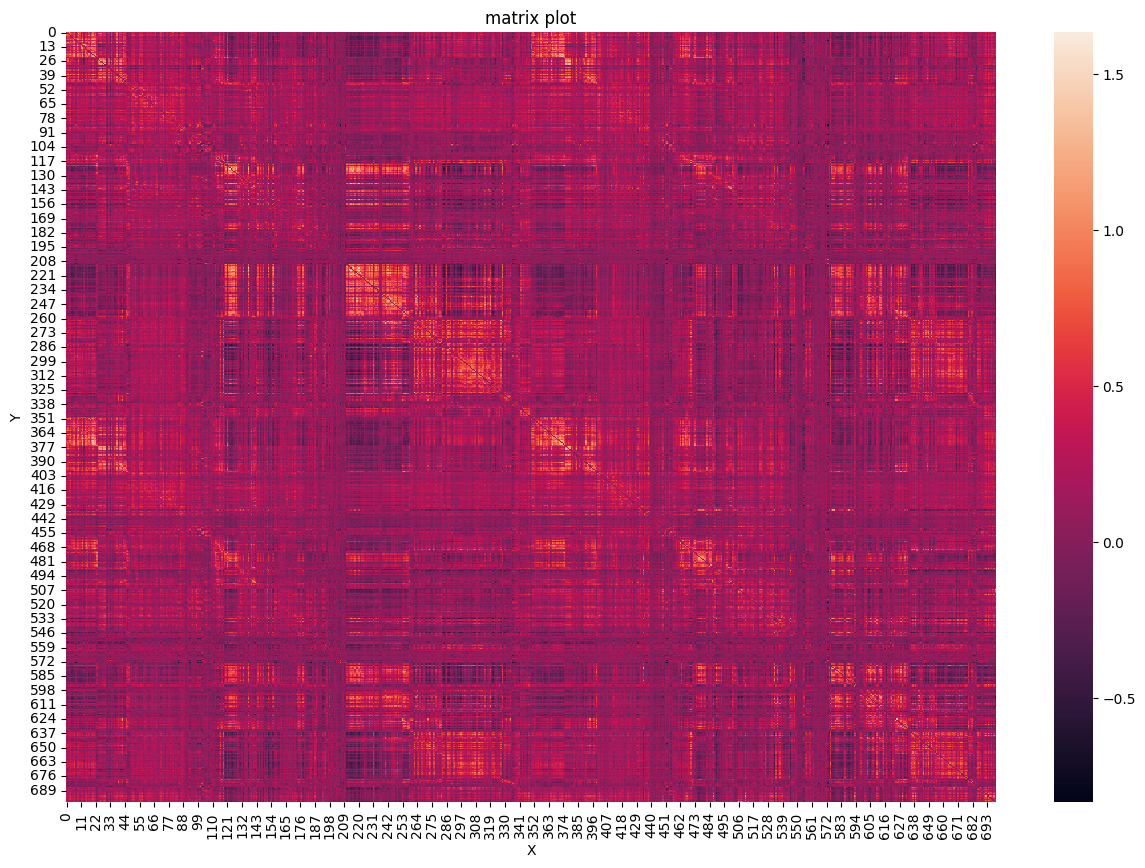

In [189]:

atlas='schaefer-700'
func_acq='desc-se_task-rest_acq-AP_bold'
func_file = subjectDir + '/func/'+func_acq+'/surf/' + subjectID + '_surf-fsLR-32k_atlas-' + atlas + '_desc-FC.txt'

fc_mtx, mask, labels = load_mtx(func_file, atlas, 'FC')
plot_connectome(fc_mtx)

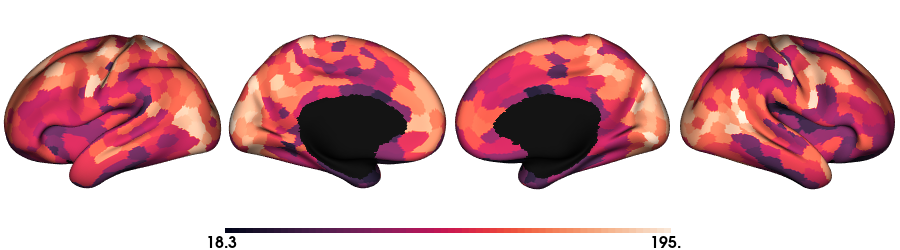

In [190]:
# surface plotting
fc_pos = np.copy(fc_mtx)
fc_pos[(0>fc_pos)] = 0
mtx_F = np.sum(fc_pos,axis=1)

# ---------------------------------
F_surf = map_to_labels(mtx_F, labels, fill=np.nan, mask=mask)

# Plot surface data 
plot_hemispheres(c69_lhi, c69_rhi, array_name=F_surf, size=(900, 250), color_bar='bottom', zoom=1.25, 
                 embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='rocket',transparent_bg=False)

In [191]:
# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

# mask of the medial wall
mask_c69 = load_mask(join=True)


FC = np.loadtxt(func_file, dtype=float, delimiter=' ')
print(FC.shape)
# slice the matrix
FC = FC[49:, 49:]
#FC = np.delete(np.delete(FC, 200, axis=0), 200, axis=1)

# Fischer transformation
FCz = np.arctanh(FC)

# replace inf with 0
FCz[~np.isfinite(FCz)] = 0

# Mirror the matrix
FCz = np.triu(FCz,1)+FCz.T

# Load annotations
lh_lab = nb.freesurfer.io.read_annot(micapipe + '/parcellations/lh.' + atlas + '_mics.annot')
rh_lab = nb.freesurfer.io.read_annot(micapipe + '/parcellations/rh.' + atlas + '_mics.annot')
labs = lh_lab[2][1:] + rh_lab[2][1:]


(749, 749)


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_18826/3643136329.py:15: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


In [192]:
def smooth_surf(surf_l, surf_r, points, Kernel='uniform', Niter=20, Relax=0.5, Mask=mask_c69):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional NUmber of smooth iterations
    Relax  : relax : float, optional relaxation facto
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    n2dim = int(Mask.shape[0]/2)
    Mask_l=mask_c69[0:n2dim]
    Mask_r=mask_c69[n2dim:Mask.shape[0]]
    sdata = np.concatenate((smooth_array(surf_l, points[0:32492],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[32492:64984],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

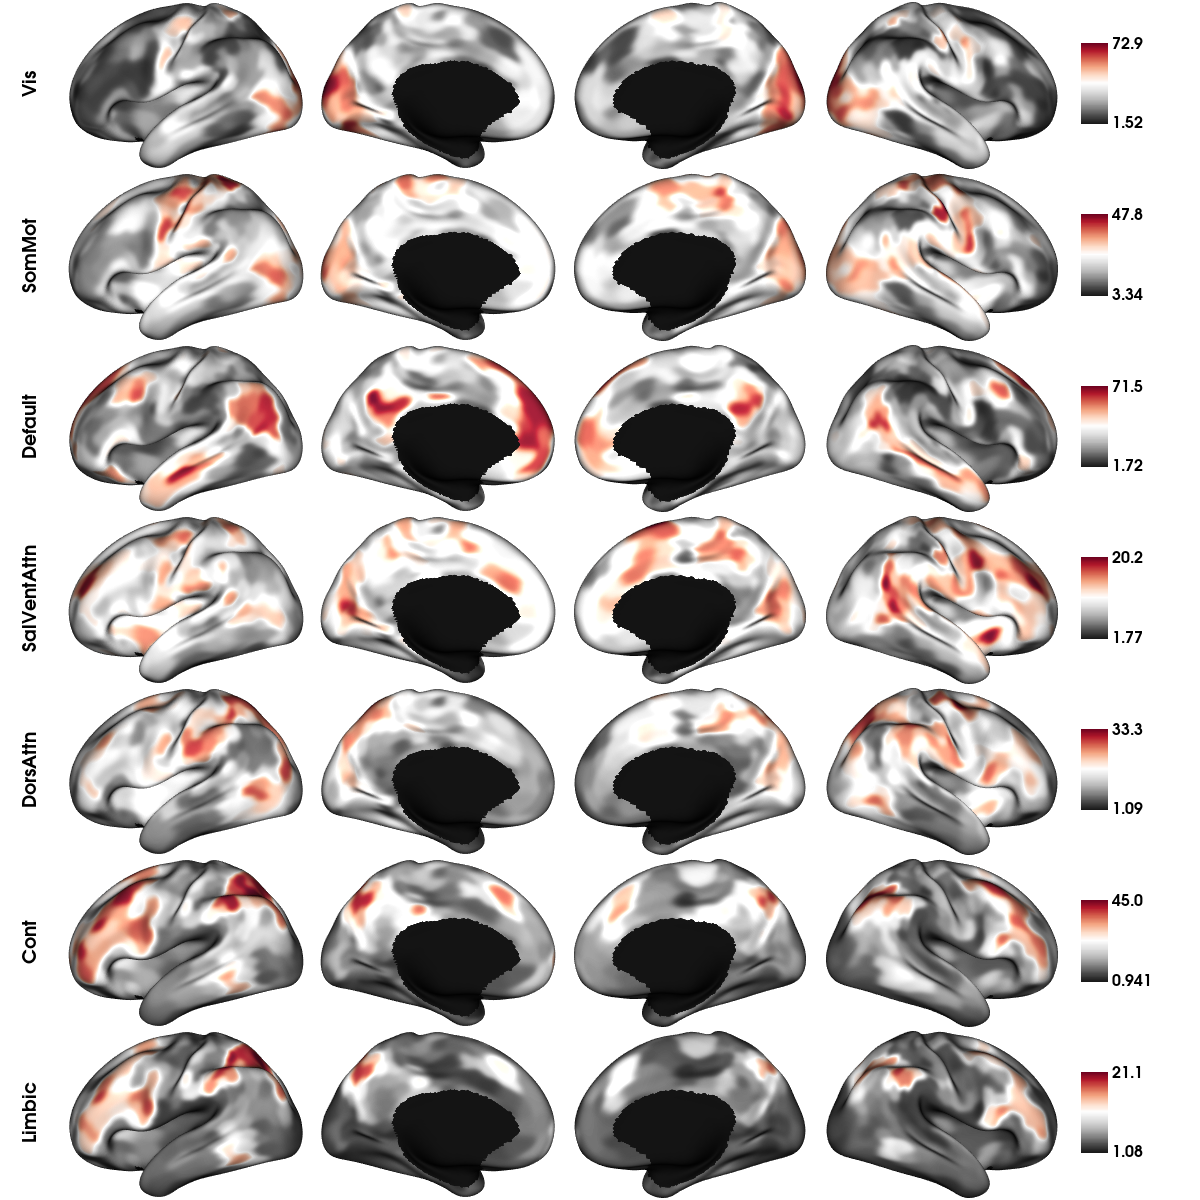

In [193]:
# Load annotations
lh_lab = nb.freesurfer.io.read_annot(micapipe + '/parcellations/lh.' + atlas + '_mics.annot')
rh_lab = nb.freesurfer.io.read_annot(micapipe + '/parcellations/rh.' + atlas + '_mics.annot')
labs = lh_lab[2][1:] + rh_lab[2][1:]

# Plot each YEO network
netStrs = ['Vis', 'SomMot', 'Default', 'SalVentAttn', 'DorsAttn', 'Cont', 'Limbic' ]
networks = [None] * len(netStrs)

# # Positive correlations
# fc_pos = np.copy(FCz)
# fc_pos[(0>fc_pos)] = 0

for i, netNom in enumerate(netStrs):
    #print(str(i) + ' ' + netNom)
    indx = [netNom in str(x) for x in labs]
    net = np.sum(fc_pos[indx,:], axis=0)
    networks[i] = map_to_labels(net, labels_c69, fill=np.nan, mask=mask_c69)
    networks[i] = smooth_surf(c69_lhi, c69_rhi,networks[i], Niter=10)
    del(net)

# YEO networks
plot_hemispheres(c69_lhi, c69_rhi, array_name=networks, size=(1200, 1200), cmap='RdGy_r',
                 embed_nb=True,  label_text={'left':netStrs}, color_bar='right',
                 zoom=1.75, nan_color=(0, 0, 0, 1), interactive=False, background=(0,0,0),
                screenshot=False, filename='/home/bic/rcruces/Desktop/FC_yeo-sumpos.png')


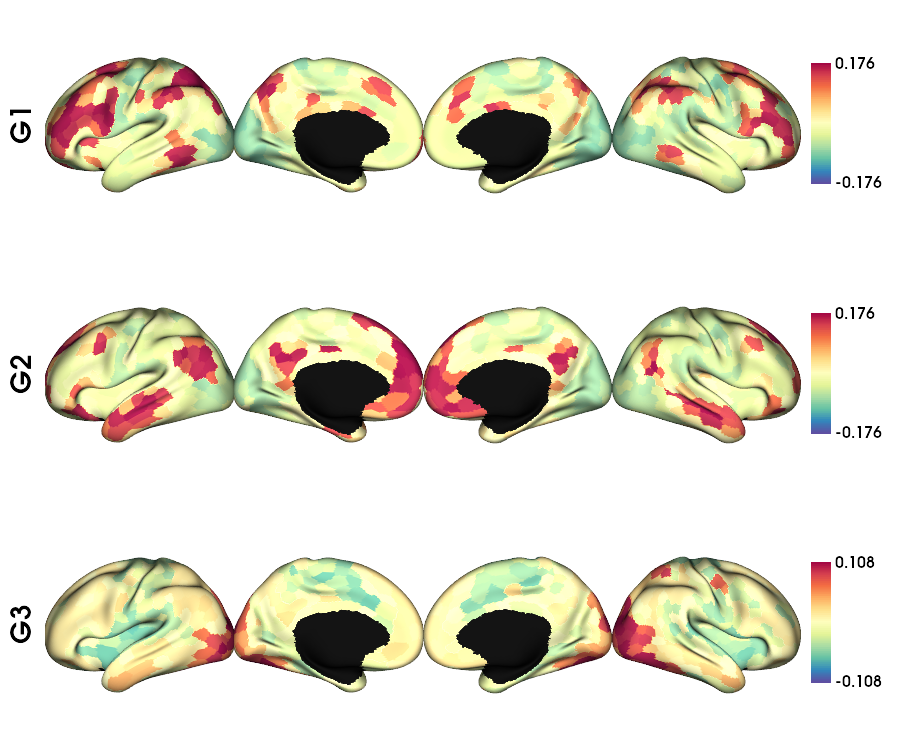

In [194]:
# Calculate the gradients
Ngrad=3
gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
gm.fit(fc_mtx, sparsity=0.9)

# Map gradients to original parcels
grad = [None] * Ngrad
for i, g in enumerate(gm.gradients_.T[0:Ngrad,:]):
     grad[i] = map_to_labels(g, labels, fill=np.nan, mask=mask)


# Plot Gradients RdYlBu
lab=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(c69_lhi, c69_rhi, array_name=grad, cmap='Spectral_r',
                  embed_nb=True,  label_text={'left':lab}, color_bar='right',
                  zoom=1.3, size=(900, 750), nan_color=(0, 0, 0, 1), color_range='sym',
                  screenshot=False, filename='/home/bic/rcruces/Desktop/FC_'+subjectID+'_'+atlas+'.png') 